In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import cvxpy as cp

from decentr_quad_constraint_20node import *
import ciropt as co

In [2]:
# random seed
np.random.seed(108)

# data generation
problem_spec = {}
problem_spec['n_node'] = 20
problem_spec['vector_size'] = 10
# problem_spec['vector_size'] = 50
problem_spec['sc_theta'] = 0.5
problem_spec['sc_perturb'] = False
# problem_spec['sc_index_set'] = set(range(0, 20))
problem_spec['sc_index_set'] = set(range(0, 10))
# problem_spec['sc_index_set'] = {0,1,2,3,4,5}
# problem_spec['sc_index_set'] = {3,4}
# problem_spec['sc_index_set'] = {}
print(problem_spec)
problem_data = data_generation(problem_spec)
network_data = graph_generation(problem_spec['n_node'])
problem_data['itr_num'] = 1000


{'n_node': 20, 'vector_size': 10, 'sc_theta': 0.5, 'sc_perturb': False, 'sc_index_set': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}}


In [3]:
Q = problem_data['Q']
b = problem_data['b']
n_node = problem_spec['n_node']
vector_size = problem_spec['vector_size']
sc_index_set = problem_spec['sc_index_set']

for j in range(n_node):
    U, s, V = np.linalg.svd(Q[j])
    print([np.max(s), np.average(s), np.min(s)])

[20.43517924156465, 7.774511076965181, 0.1543179983057755]
[31.644419863141355, 8.261101167183655, 0.0005845570058076898]
[37.587221814192645, 10.446106453134535, 0.06062115594318295]
[29.2009357376931, 9.874548866861806, 0.14938344276862833]
[20.079296255452242, 7.512712024088619, 0.0015365145786865589]
[27.45882041825525, 9.292348966804024, 7.955724871000527e-05]
[32.917907675129015, 9.386124539235384, 0.04420165449606073]
[25.384216979489114, 8.469446944107014, 0.0012151797170874207]
[31.62762812859239, 9.624456093266216, 0.1637271438940105]
[30.797837428278285, 8.264692686714502, 0.06133405330159842]
[27.073890809590587, 9.493134029522192, 0.018291364465808865]
[24.485088739341357, 8.986104307432615, 0.011412963665199756]
[23.480415545497394, 8.980594631375943, 0.10300370909822655]
[26.872199976539815, 8.907912332811861, 0.24733180389636727]
[31.460129441239815, 8.757915797214855, 0.002100955034507331]
[30.98355721374, 8.941881955312557, 9.414451215764855e-06]
[26.664373593703132, 

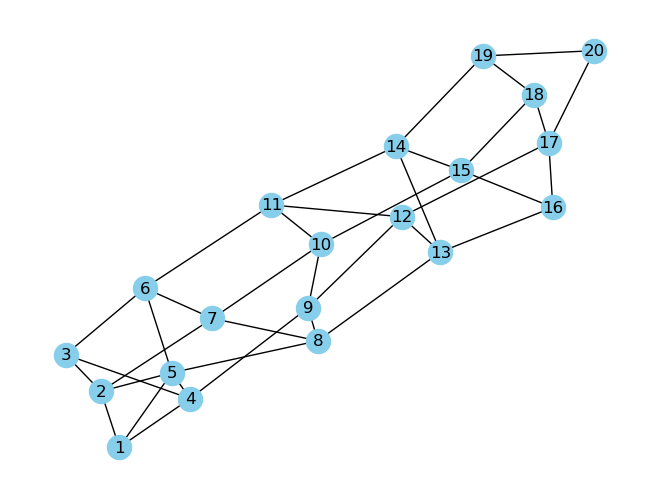

In [4]:
nx.draw(network_data["G"], node_color='skyblue', with_labels=True)
plt.savefig("plots/graph_n6.pdf")

In [5]:
f_star, x_opt_star = min_cvx_quad_no_constraint(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=-0.42978706414720225, np.linalg.norm(x_opt_star)=0.06964956402569608


In [6]:
f_star, x_opt_star = min_quad_no_constraint(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=-0.4297870641472023, np.linalg.norm(x_opt_star)=0.06964956402569608


In [7]:
Q = problem_data['Q']
b = problem_data['b']
 
vector_size = problem_spec['vector_size']
n_node = problem_spec['n_node']
prox_operators = []
fi_operators = []

# Define functions and proximal operators to implement the method
for jj in range(n_node):
    Qj = Q[jj]
    bj = b[jj]
    # prox_operators += [lambda z, rho: cvx_prox_fj_quad_no_constraint(z, rho, problem_spec, problem_data, jj) ]
    prox_operators += [lambda z, rho, Qj=Qj, bj=bj, vector_size=vector_size : prox_fj_quad_no_constraint(z, rho, Qj, bj, vector_size) ]
    fi_operators += [lambda x_kj, Qj=Qj, bj=bj : 1/2 * x_kj @ Qj @ x_kj.T + np.dot(bj[0], x_kj) ]

    c = np.random.randn(vector_size)
    x1 = prox_operators[-1](c, 1/5)
    x2 = cvx_prox_fj_quad_no_constraint(c, 1/5, problem_spec, problem_data, jj, eps=1e-4)
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-5

In [8]:
# problem_data['rho'] = 1
# params={"R":1, "Capacitance":1, "h":0.561455037879421}

# pg_c_op_norm, pg_c_err_opt_star, pg_c_err_opt_reldiff, pg_c_const_vio, pg_c_f_reldiff = co.pg_extra("pg_extra_c", problem_spec, problem_data, 
#                                                                         network_data, x_opt_star, f_star, prox_operators=prox_operators,
#                                                                         fi_operators=fi_operators,
#                                                                         params=params, printing=True, sc_index_set = sc_index_set, freq=200)

In [9]:
# apply P-EXTRA 
best_rho = 1
find_best = True

# problem_data['rho'] = 0.01
# problem_data['rho'] = 0.1
# problem_data['rho'] = 0.2
# problem_data['rho'] = 0.5

start, end, space = 0.1, 3, 0.1
# start, end, space = 0.1, 0.3, 0.01
# start, end, space = 0.1, 2, 0.1

best_value = 1

if find_best == True:
    for r in np.arange(start, end, space) :
        problem_data['rho'] = round(r, 2)
        # print("Testing rho :", r)
        pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = co.pg_extra("pg_extra", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        fi_operators=fi_operators,
                                                                        printing=False, freq=200)
        # new_val = sum(pg_f_reldiff[-10:]) / 10
        # new_val = sum(pg_f_reldiff[-300:]) / 300
        # new_val = sum(pg_f_reldiff[-300:-200]) / 100
        new_val = sum(pg_f_reldiff[300:400]) / 100
        if new_val < best_value:
            print("new best_rho :", round(r, 2),  "new best_value :", new_val)
            best_value = new_val
            best_rho = round(r, 2)

print("best_rho :",best_rho)

new best_rho : 0.1 new best_value : 1.2733821939712411e-05
best_rho : 0.1


In [10]:
problem_data['rho'] = best_rho
# problem_data['rho'] = 1


# pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = p_extra_quad_no_constraint(problem_spec, problem_data, network_data, x_opt_star, f_star, printing=True, freq=200)

pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = co.pg_extra("pg_extra", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        fi_operators=fi_operators,
                                                                        printing=True, freq=200)

ii=0, f_reldiff[-1]=144.60410107415575, err_opt_reldiff[-1]=0.2940628622990642
ii=200, f_reldiff[-1]=0.0015470404310847024, err_opt_reldiff[-1]=2.1186568361888248e-05
ii=400, f_reldiff[-1]=1.5801644537679976e-06, err_opt_reldiff[-1]=5.8383160320361974e-08
ii=600, f_reldiff[-1]=3.2975060590068927e-09, err_opt_reldiff[-1]=2.3856605170394105e-10
ii=800, f_reldiff[-1]=1.0265480645545997e-11, err_opt_reldiff[-1]=1.0320729168447972e-12
ii=999, f_reldiff[-1]=3.991033505043739e-14, err_opt_reldiff[-1]=4.625555036505968e-15


In [11]:
best_R = 1
find_best = True

# R = 18
start, end, space = 0.1, 2, 0.1

best_value = 1

if find_best == True:
    for r in np.arange(start, end, space) :
        R = round(r, 2)
        # print("Testing R :", r)
        admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params={"R":R}, printing=False, freq=200)
        # new_val = sum(admm_f_reldiff[-10:]) / 10
        # new_val = sum(admm_f_reldiff[-300:]) / 300
        # new_val = sum(admm_f_reldiff[-300:-200]) / 100
        new_val = sum(admm_f_reldiff[300:400]) / 100
        if new_val < best_value:
            print("new best_R :", round(r, 2),  ", new best_value :", new_val)
            best_value = new_val
            best_R = round(r, 2)

print("best_R :", best_R)

new best_R : 0.1 , new best_value : 3.061083950470443e-16
best_R : 0.1


In [12]:
R = best_R
# R = 3
# R = 2
# R = 1
# R = 0.5
admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        fi_operators=fi_operators,
                                                                        params={"R":R}, printing=True, freq=200)


ii=0, f_reldiff[-1]=10.02306480570181
ii=200, f_reldiff[-1]=2.2852412446525767e-10
ii=400, f_reldiff[-1]=2.5831932071480506e-16
ii=600, f_reldiff[-1]=0.0
ii=800, f_reldiff[-1]=3.8747898107220764e-16
ii=999, f_reldiff[-1]=2.5831932071480506e-16


In [45]:
problem_data['rho'] = best_rho
# params={"R":1, "Capacitance":1, "h":0.561455037879421}
# params={"R":best_rho, "Capacitance":1, "h":0.561455037879421}
# params={"R":0.5, "Capacitance":0.2, "h":1.2}
# params={"R":best_rho, "Capacitance":0.1, "h":0.5}
# params={"R":0.24, "Capacitance":0.11, "h":1}
params={"R":0.025, "Capacitance":0.1, "h":0.6}
# params={"R":1, "Capacitance":0.01, "h":0.5}

pg_c_op_norm, pg_c_err_opt_star, pg_c_err_opt_reldiff, pg_c_const_vio, pg_c_f_reldiff = co.pg_extra("pg_extra_par_c", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        fi_operators=fi_operators,
                                                                        params=params, printing=True, sc_index_set = sc_index_set, freq=200)

ii=0, f_reldiff[-1]=395.24015201620335, err_opt_reldiff[-1]=0.40008075976456314
ii=200, f_reldiff[-1]=6.99334981005156e-12, err_opt_reldiff[-1]=2.2446440480059989e-13
ii=400, f_reldiff[-1]=5.166386414296101e-16, err_opt_reldiff[-1]=9.533750057573054e-18
ii=600, f_reldiff[-1]=0.0, err_opt_reldiff[-1]=9.950746824738789e-18
ii=800, f_reldiff[-1]=7.749579621444153e-16, err_opt_reldiff[-1]=1.2019591643962554e-17
ii=999, f_reldiff[-1]=1.2915966035740253e-16, err_opt_reldiff[-1]=1.2920138868245608e-17


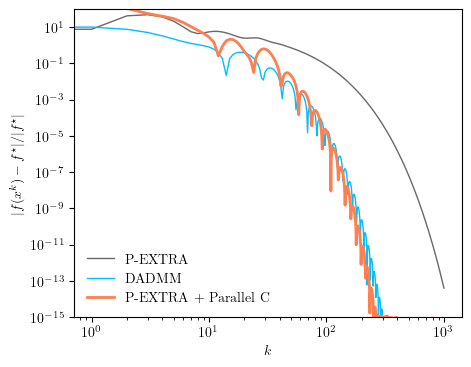

In [46]:
fname = "n6_qp_circuit_pg_c"

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 4
plt.rcParams["legend.framealpha"] = 0.0
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["mathtext.fontset"] = 'cm' # default = 'dejavusans', other options = 'cm', 'stixsans', 'dejavuserif'
black, red, blue, green = 'dimgrey', 'coral', 'deepskyblue', 'green'

# operator norm plot (log-log plot)
plt.figure(figsize=(5,4))
plt.minorticks_off()
plt.xscale("log")
plt.yscale("log")
plt.plot(pg_f_reldiff, label='P-EXTRA', color=black, linewidth=1)
plt.plot(admm_f_reldiff, label='DADMM', color=blue, linewidth=1)
# plt.plot(dadmm_c_all_f_reldiff, label='Circuit DADMM + C-All',  color=green, linewidth=1)
# plt.plot(dadmm_c_f_reldiff, label='Circuit DADMM + C',  color=red, linewidth=2)
plt.plot(pg_c_f_reldiff, label='P-EXTRA + Parallel C',  color=red, linewidth=2)
# plt.plot(pg_R_f_reldiff, label='PG-EXTRA + R',  color=red, linewidth=2)
plt.xlabel(r"$k$")
plt.ylabel(r"$|f(x^k) - f^\star|/|f^\star|$")
# plt.ylabel(r"$\|\tilde{\mathbf{A}}x_k\|^2_M$")
plt.ylim(1e-15, 1e+2)
# plt.autoscale(enable=True, axis='y', tight=None)
plt.legend()
plt.savefig(f'plots/freldif_{fname}.pdf', dpi=300)